<br>

<h1>
    <center>
        Estimating $\pi$ using a Qauntum Computer
    </center>
</h1>

## Table of Contents


0. [Define Problem](#0.-Define-Problem)
1. [Import Libraries](#)
2. [Estimate $\pi$ using Taylor Series Expansion](#) 
3. [Estimate $\pi$ using Monte Carlo Simulation with Numpy](#)
4. [Estimate $\pi$ using Quantum Accelerated Monte Carlo Simulation](#) 
    * Generate Random 8-bit Numbers
    * Normalize Random Numbers Between [0,1]
    * Measure Circle vs. Square Ratio
5. [Analysis of Performance](#)
    * Accuracy
    * Speed
6. [Conclusion - Which is better?](#)

### 0. Define Problem

#### Approximating $\pi$ as a Series:


$$\frac{\pi}{4} = \frac{(-1)^{n}}{2n-1} \rightarrow  \pi = 4\frac{(-1)^{n}}{2n-1}$$


#### Aproximate $\pi$ via Monte Carlo Simulation

![MC_Simulation](Monte_Carlo_Approximation.gif)

### 1. Import Libraries

In [1]:
# import visulaization tool
import seaborn as sns
import matplotlib.pyplot as plt

# import numerical processing tool
import numpy as np

# data handeling
import pandas as pd

# measure time/duration 
import time

# import quantum simulation tools
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import BasicAer, execute
import pylatexenc

### 2. Estimate $\pi$ using Taylor Series Expansion

$$ \pi = 4 \sum_{n=1}^{i} \frac{(-1)^{n}}{2n-1}$$

In [ ]:
def GenerateTaylorSeries(x):
    """
    Input:
        x | int | numebr of iterations to approximate taylor series expansion pi/4
    Output:
        pi_aproximation | float | approximation of pi        
    """
        
    iteration_value = [(1**(2*i+1)*(-1)**i)/(2*i+1) for i in np.arange(x)]
    summation = np.sum(iteration_value)
    pi_approximation = 4 * summation
        
    return pi_approximation

In [ ]:
# establish lists to hold recorded values
pi_approximation_list = []
population_list = []
duration = [] 

for sample_size in [int(1e2), int(1e3), int(1e4), int(1e5), int(1e6)]:

    print(sample_size)
        
    # measure start time
    start = time.time()   
    
    # generate taylor series
    pi_approximation = GenerateTaylorSeries(x = sample_size)
    
    # measure stop time
    stop = time.time()
    
    # record keeping
    duration.append(stop-start)        
    pi_approximation_list.append(pi_approximation)
    population_list.append(sample_size)
    
TaylorSeries_Performance = (
    pd
    .DataFrame(
        data = list(zip(pi_approximation_list, population_list, duration)),
        columns = ['pi_approximatation', 'population', 'duration']
    )
    .assign(        
        error = lambda x: x['pi_approximatation'] - np.pi
    )   
)

TaylorSeries_Performance

### 3. Estimate $\pi$ using Monte Carlo Simulation with Numpy

In [2]:
# establish lists to hold recorded values
pi_approximation_list = []
population_list = []
duration = [] 

for sample_size in [int(1e2), int(1e3), int(1e4), int(1e5), int(1e6)]:

    print(sample_size)
        
    # measure start time
    start = time.time()   
    
    # generate x values
    x = np.random.random_sample(sample_size)
    # generate y values
    y = np.random.random_sample(sample_size)
    
    # create MC 
    mc_values = np.sqrt(np.square(x) + np.square(y))
    pi_approximation = 4*len(mc_values[mc_values < 1]) / len(x)
    
    # measure stop time
    stop = time.time()
    
    # record keeping
    duration.append(stop-start)        
    pi_approximation_list.append(pi_approximation)
    population_list.append(sample_size)

100
1000
10000
100000
1000000


In [3]:
Numpy_Performance = (
    pd
    .DataFrame(
        data = list(zip(pi_approximation_list, population_list, duration)),
        columns = ['pi_approximatation', 'population', 'duration']
    )
    .assign(        
        error = lambda x: x['pi_approximatation'] - np.pi
    )   
)

Numpy_Performance

,pi_approximatation,population,duration,error
0,3.040000,100,0.000000,-0.101593
1,3.204000,1000,0.000000,0.062407
2,3.159600,10000,0.000000,0.018007
3,3.144720,100000,0.000000,0.003127
4,3.140612,1000000,0.021001,-0.000981


In [7]:
def CreateCircuit(bits):
    """
    Input:
        bits | int | defines how many q-bits the circuit involves
    Output:
        circuit | qiskit.circuit | establish a circuit to randomly generate 8-bit binary numbers
        circuit_diagram | matplotlib.figure | figure that depicts the q-bit to c-bit figure
    """    
    
    # define quantum register | classical register
    q = QuantumRegister(bits);  c = ClassicalRegister(bits)
    
    # define circuit
    circuit = QuantumCircuit(q, c)
    
    # use for loops to add q-bits and hadamar gates to the existing circuit
    for j in range(bits): circuit.h(q[j])
    
    # add measurements to transfer from q-bit to classical-bit
    circuit.measure(q, c)
    
    # draw circuit
    circuit_drawing = circuit.draw(output='mpl')
    
    # return circuit and drawing
    #return (circuit, circuit_drawing)
    return circuit

In [8]:
def GenerateRandomNumbers_QC(circuit, sample_size):
    """
    Input:
        circuit | qiskit.circuit | establish a circuit to randomly generate 8-bit binary numbers
        sample_size | int | number of iterations to generate 8-bit numbers
    Output:
        numbers | list(int) | list of binary numbers generated by the circuit
    """   
    
    # generate binary numbers
    binary_numbers = execute(
        experiments = circuit,
        backend = BasicAer.get_backend('qasm_simulator'),
        shots = sample_size,
        memory = True
    )
    
    # convert binary numbers to integers
    numbers = np.array([int(i, 2) for i in binary_numbers.result().get_memory()])
    
    return numbers

In [9]:
def NormalizeNumbers(numbers):
    """
    Input:
        numbers | list(int) | list of binary numbers generated by the circuit
    Output:
        normalized_values | list(float) | list of normalized numbers between [0,1]
    """
    minimum = min(numbers)
    maximum = max(numbers)
    
    normalized_values = np.array([(num - maximum) / (maximum - minimum) for num in numbers])
    
    return normalized_values

In [10]:
# establish circute
bits = 8
circuit = CreateCircuit(bits = bits)

# establish lists to hold recorded values
pi_approximation_list = []
population_list = []
duration = [] 

# perform iterations    
for sample_size in [int(1e2), int(1e3), int(1e4), int(1e5), int(1e6)]:

    print(sample_size)
        
    # measure start time
    start = time.time()   
    
    # generate x values
    x = NormalizeNumbers(GenerateRandomNumbers_QC(circuit = circuit, sample_size = sample_size))
    # generate y values
    y = NormalizeNumbers(GenerateRandomNumbers_QC(circuit = circuit, sample_size = sample_size))
    
    # create MC 
    mc_values = np.sqrt(np.square(x) + np.square(y))
    pi_approximation = 4*len(mc_values[mc_values < 1]) / len(x)
    
    # measure stop time
    stop = time.time()
    
    # record keeping
    duration.append(stop-start)        
    pi_approximation_list.append(pi_approximation)
    population_list.append(sample_size)

100
1000
10000
100000
1000000


In [11]:
QuantumComputing_Performance = (
    pd
    .DataFrame(
        data = list(zip(pi_approximation_list, population_list, duration)),
        columns = ['pi_approximatation', 'population', 'duration']
    )
    .assign(        
        error = lambda x: x['pi_approximatation'] - np.pi
    )   
)

QuantumComputing_Performance

,pi_approximatation,population,duration,error
0,3.04000,100,0.067158,-0.101593
1,3.18400,1000,0.016404,0.042407
2,3.13240,10000,0.133715,-0.009193
3,3.12756,100000,1.199413,-0.014033
4,3.13318,1000000,12.400432,-0.008413


In [31]:
TaylorSeries_Performance = TaylorSeries_Performance.assign(method = 'TaylorSeries')
Numpy_Performance = Numpy_Performance.assign(method = 'NumpyMC')
QuantumComputing_Performance = QuantumComputing_Performance.assign(method = 'QCMC')

Performance_DataFrame = (
    pd
    .concat(
        [TaylorSeries_Performance, Numpy_Performance, QuantumComputing_Performance]
    )
    [['method', 'population', 'duration', 'pi_approximatation', 'error']]
)

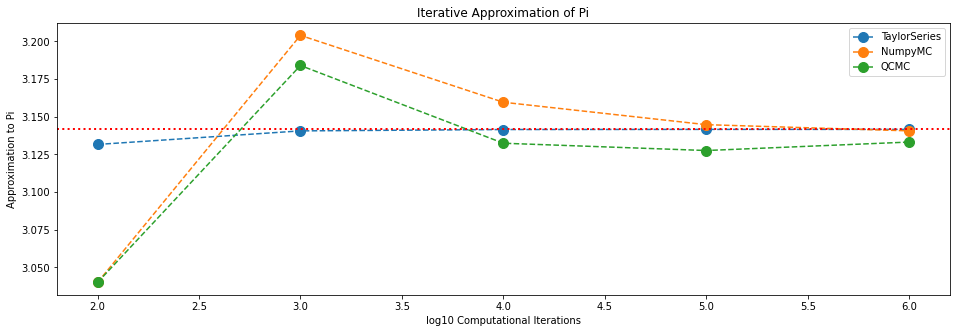

In [67]:
fig, ax0 = plt.subplots()

for algorithm in ['TaylorSeries', 'NumpyMC', 'QCMC']:
    (
        Performance_DataFrame
        .query(f"method == '{algorithm}'")
        .assign(log_pop = lambda x: np.log10(x['population']))
        .plot(
            x = 'log_pop',
            y = 'pi_approximatation',
            ax = ax0,
            style = "o--",
            markersize = 10,            
            xlabel = "log10 Computational Iterations",
            ylabel = "Approximation to Pi",
            title = "Iterative Approximation of Pi",
            figsize = (16, 5),
        )
    )
    
ax0.legend(['TaylorSeries', 'NumpyMC', 'QCMC'])
plt.axhline(
    y = np.pi,
    xmin = 0, xmax = Performance_DataFrame.population.max(),
    color = 'red',
    linewidth = 2,
    linestyle = 'dotted'
)

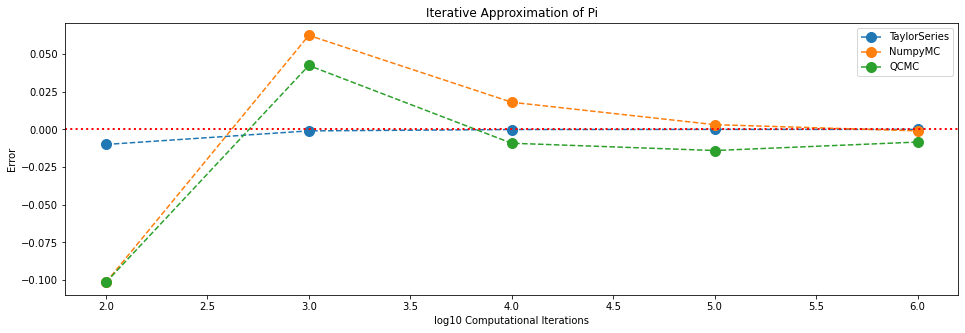

In [68]:
fig, ax0 = plt.subplots()

for algorithm in ['TaylorSeries', 'NumpyMC', 'QCMC']:
    (
        Performance_DataFrame
        .query(f"method == '{algorithm}'")
        .assign(log_pop = lambda x: np.log10(x['population']))
        .plot(
            x = 'log_pop',
            y = 'error',
            ax = ax0,
            style = "o--",
            markersize = 10,            
            xlabel = "log10 Computational Iterations",
            ylabel = "Error",
            title = "Iterative Approximation of Pi",
            figsize = (16, 5),
        )
    )
    
ax0.legend(['TaylorSeries', 'NumpyMC', 'QCMC'])
plt.axhline(
    y = 0,
    xmin = 0, xmax = Performance_DataFrame.population.max(),
    color = 'red',
    linewidth = 2,
    linestyle = 'dotted'
)